# Doublet Finder

Source code: `https://github.com/chris-mcginnis-ucsf/DoubletFinder`

### Setup and Load Data


In [9]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os
import anndata

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

sample_name = r'sc85_1g'

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
os.getcwd()


'/Volumes/SSD/McKinnonRosatiLab/Project2/DblDetection/Methods/DoubletFinder'

### Set Up R Environment

In [3]:
os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"

import anndata2ri # order matters, comes after defining 'R_HOME
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/var/folders/v8/ptd2qrdj11bf42tp5y0_42700000gn/T/ipykernel_30182/1227126012.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [13]:
%%R
library(tidyverse) # includes ggplot2, for data visualisation. dplyr, for data manipulation.
library(Seurat)
library(DoubletFinder)
library(SeuratDisk)


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


In [10]:
adata = anndata.read_h5ad("../../raw_data/pseudo_sc85/pseudo_doublets_sc85_1g_2.0.h5ad")                # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

print()
print(adata.obs)

Data matrix is sparse: True

Number of cells = 12,184
Number of genes = 25,051
Number of counts = 8,337,388
Mean counts per cell = 684

Empty DataFrame
Columns: []
Index: [rDbl.1, rDbl.2, rDbl.3, rDbl.4, rDbl.5, rDbl.6, rDbl.7, rDbl.8, rDbl.9, rDbl.10, rDbl.11, rDbl.12, rDbl.13, rDbl.14, rDbl.15, rDbl.16, rDbl.17, rDbl.18, rDbl.19, rDbl.20, rDbl.21, rDbl.22, rDbl.23, rDbl.24, rDbl.25, rDbl.26, rDbl.27, rDbl.28, rDbl.29, rDbl.30, rDbl.31, rDbl.32, rDbl.33, rDbl.34, rDbl.35, rDbl.36, rDbl.37, rDbl.38, rDbl.39, rDbl.40, rDbl.41, rDbl.42, rDbl.43, rDbl.44, rDbl.45, rDbl.46, rDbl.47, rDbl.48, rDbl.49, rDbl.50, rDbl.51, rDbl.52, rDbl.53, rDbl.54, rDbl.55, rDbl.56, rDbl.57, rDbl.58, rDbl.59, rDbl.60, rDbl.61, rDbl.62, rDbl.63, rDbl.64, rDbl.65, rDbl.66, rDbl.67, rDbl.68, rDbl.69, rDbl.70, rDbl.71, rDbl.72, rDbl.73, rDbl.74, rDbl.75, rDbl.76, rDbl.77, rDbl.78, rDbl.79, rDbl.80, rDbl.81, rDbl.82, rDbl.83, rDbl.84, rDbl.85, rDbl.86, rDbl.87, rDbl.88, rDbl.89, rDbl.90, rDbl.91, rDbl.92, rDbl.93, 

In [11]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame({"Number of cells": [n_cells],
                          "Number of genes": [n_genes], 
                          "Number of counts": [n_counts], 
                          "Mean counts per cell": [counts_per_cell]}, 
                          index=[sample_name])


df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].map('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

/var/folders/v8/ptd2qrdj11bf42tp5y0_42700000gn/T/ipykernel_30182/1653201150.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sc85_1g    25,051
Name: Number of genes, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].map('{:,.0f}'.format)
/var/folders/v8/ptd2qrdj11bf42tp5y0_42700000gn/T/ipykernel_30182/1653201150.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sc85_1g    8,337,388
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].map('{:,.0f}'.format)
/var/folders/v8/ptd2qrdj11bf42tp5y0_42700000gn/T/ipykernel_30182/1653201150.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc85_1g,12184,"25,051","8,337,388",684


In [12]:
data_mat = adata.X.T                 # transform data matrix
doublet_ratio = n_cells/1000*0.008   # calculate multiplet rate based on 10x formula
print('multiplet rate = %4.1f' %(doublet_ratio*100), '%')

multiplet rate =  9.7 %


### Create and Read Seurat Object
Includes preprocessing

In [14]:
%%R
# expression_matrix <- ReadMtx(
#   mtx = "../raw_data/sc92_1_filtered/matrix.mtx.gz", features = "../raw_data/sc92_1_filtered/features.tsv.gz",
#   cells = "../raw_data/sc92_1_filtered/barcodes.tsv.gz"
# )
# seu <- CreateSeuratObject(counts = expression_matrix)

Convert("../../raw_data/pseudo_sc85/pseudo_doublets_sc85_1g_2.0.h5ad", dest = "h5seurat")
seu <- LoadH5Seurat("../../raw_data/pseudo_sc85/pseudo_doublets_sc85_1g_2.0.h5seurat")


Creating h5Seurat file for version 3.1.5.9900
Adding X as data
Adding X as counts
Adding meta.features from var
Validating h5Seurat file
Initializing RNA with data
Adding counts for RNA
Adding feature-level metadata for RNA
Adding command information
Adding cell-level metadata
Adding miscellaneous information
Adding tool-specific results


In [15]:
%%R
seu <- NormalizeData(seu)
seu <- FindVariableFeatures(seu, selection.method = "vst", nfeatures = 2000)
seu <- ScaleData(seu)
seu <- RunPCA(seu)
seu <- RunUMAP(seu, dims = 1:10)


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%
PC_ 1 
Positive:  LOC107375900, lfng, LOC139061564, hoxd3a, ncam1a, chl1b, LOC107384019, hoxd4a, ptprn2, LOC107388489 
	   rfx4, rnf220a, mki67, hoxc10a, hoxc4a, meis3, hoxb3a, LOC107388508, pax3a, LOC107381640 
	   KEG92-p10, ptn, pax3b, robo1, ptch2, LOC129167721, pcdh19, KEG92-p08, KE

[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."
[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizi

Loading required package: fields
Loading required package: spam
Spam version 2.11-1 (2025-01-20) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: viridisLite

Try help(fields) to get started.
Loading required package: parallel
Normalizing layer: counts
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating fea

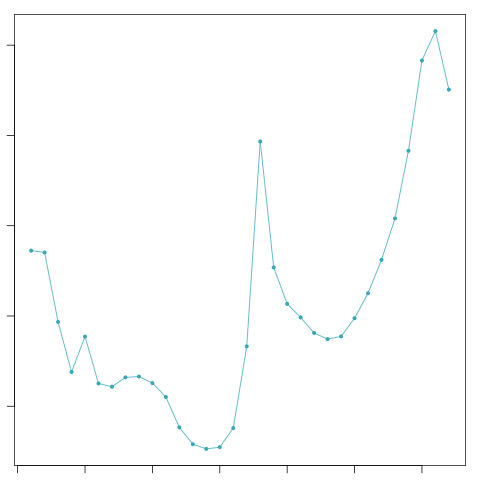

In [16]:
%%R
# Find significant PCs
sweep_list <- paramSweep(seu, PCs = 1:10, sct = FALSE)
sweep_stats <- summarizeSweep(sweep_list, GT = FALSE)
bcmvn<- find.pK(sweep_stats)

In [17]:
%%R

annotations <- seu@meta.data$seurat_clusters
homotypic.prop <- modelHomotypic(annotations)           ## ex: annotations <- seu@meta.data$ClusteringResults
nExp_poi <- round(.111 * nrow(seu@meta.data))           ## Using estimated 11.1% doublet formation rate - tailor for your dataset
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

In [18]:
%%R
colnames(seu@meta.data)


[1] "nCount_RNA"   "nFeature_RNA"


In [19]:
%%R
seu <- doubletFinder(seu, PCs = 1:10, pN = 0.25, pK = 0.09, nExp = nExp_poi, sct = FALSE)
seu <- doubletFinder(seu, PCs = 1:10, pN = 0.25, pK = 0.09, nExp = nExp_poi.adj, sct = FALSE)

[1] "Creating 4061 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."
[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "Creating 4061 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."
[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Normalizing layer: counts
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%
Normalizing layer: counts
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Findi

In [20]:
%%R 
colnames(seu@meta.data)[grepl('DF.classifications.*', colnames(seu@meta.data))] <- "doublet_finder"
  double_finder_res <- seu@meta.data['doublet_finder'] # get the metadata column with singlet, doublet info
  double_finder_res <- rownames_to_column(double_finder_res, "row_names") # add the cell IDs as new column to be able to merge correctly

In [21]:
doublet_class = ro.r('seu@meta.data$doublet_finder')
doublet_class = list(doublet_class)

doublets = [1.0 if x == 'Doublet' else 0 for x in doublet_class]
adata.obs["DoubletFinder_class"] = doublet_class
adata.obs["doublet"] = doublets

In [22]:
doublet_percentage = sum(doublets)/adata.n_obs*100
print('Doublet percentage = %4.1f' %(doublet_percentage))
df_metrics['Doublet removal:'] = ' '
df_metrics['Doublet percentage'] =  doublet_percentage

adata.obs.DoubletFinder_class.value_counts()


Doublet percentage = 11.1


DoubletFinder_class
Singlet    10832
Doublet     1352
Name: count, dtype: int64

In [23]:
num_before = adata.n_obs
singlets = adata.obs["DoubletFinder_class"] == 'Singlet'
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before doublet removal =', num_before)
print('Number of cells after doublet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After doublet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before doublet removal = 12184
Number of cells after doublet removal = 10832
Number of cells removed = 1352
Percentage of cells removed = 11.1
Number of counts = 8,337,388
Mean counts per cell = 585


## Visualization

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


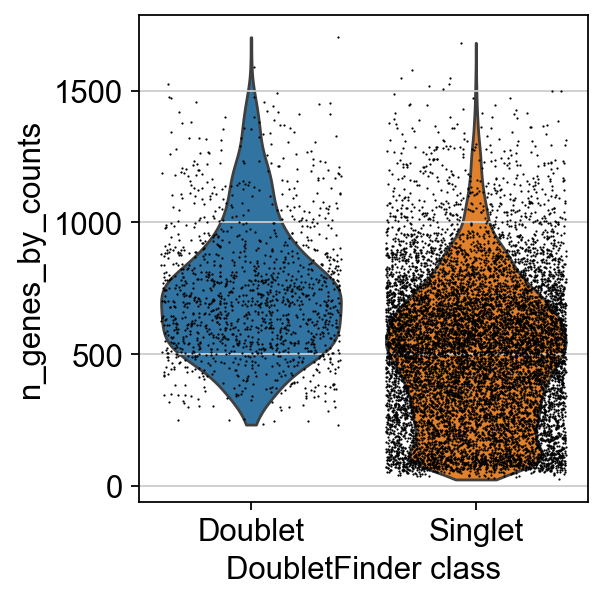

In [24]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'DoubletFinder_class')

In [25]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/christinesong/Downloads/Uni/BIO446/McKinnonRosatiLab/Project2/jl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


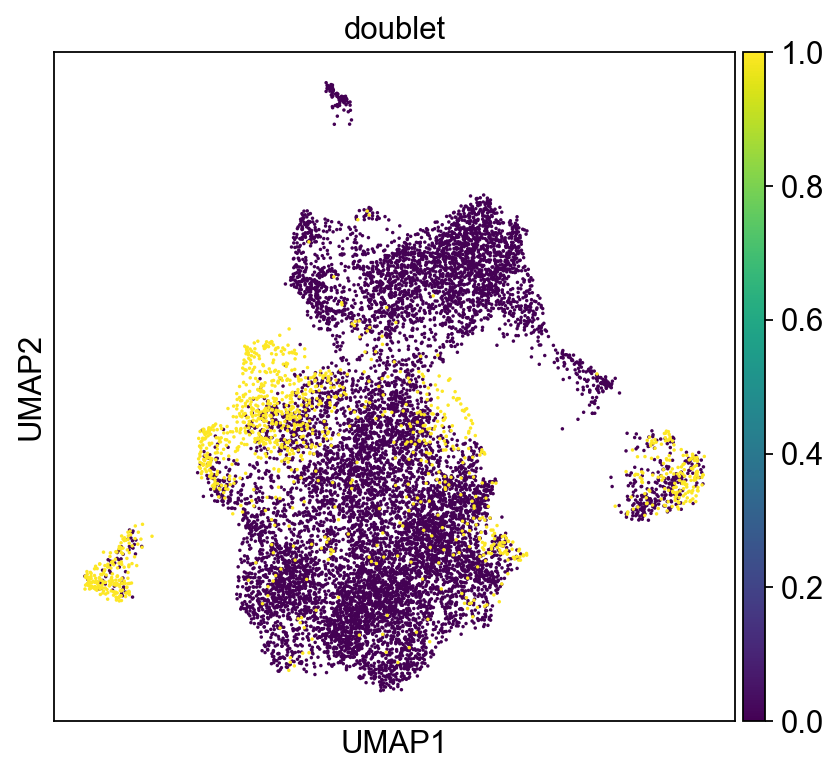

In [26]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color=['doublet'])

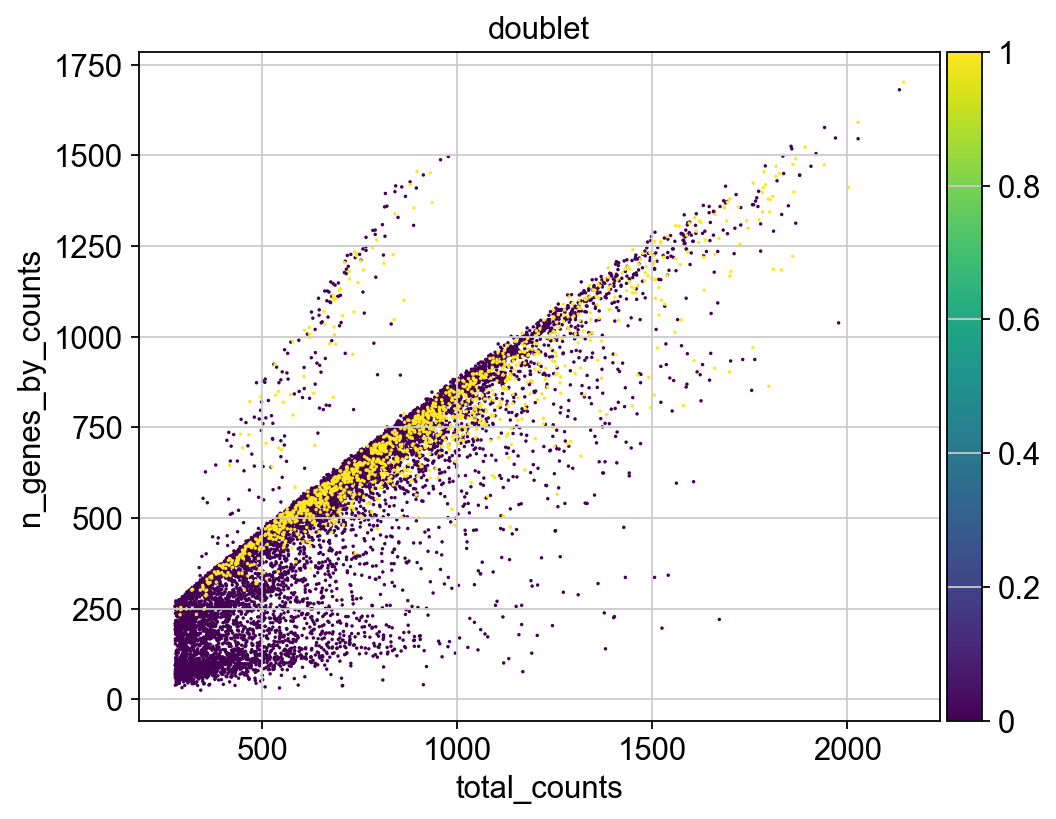

In [27]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='doublet')

### Doublet List

In [28]:
print(adata.obs[adata.obs['DoubletFinder_class'] == 'Doublet'])
adata_dbl = adata[adata.obs['DoubletFinder_class'] == 'Doublet'].copy()

                         DoubletFinder_class  doublet  n_genes_by_counts  \
rDbl.9                               Doublet      1.0                935   
rDbl.18                              Doublet      1.0               1227   
rDbl.24                              Doublet      1.0                979   
rDbl.41                              Doublet      1.0                784   
rDbl.51                              Doublet      1.0               1232   
...                                      ...      ...                ...   
TTTGGCTGTTAGTTGG_sc85_1g             Doublet      1.0                689   
TTTGGTGCACAGCCAT_sc85_1g             Doublet      1.0                678   
TTTGTCCCAGGTTATT_sc85_1g             Doublet      1.0                753   
TTTGTGAAGGACAATG_sc85_1g             Doublet      1.0                701   
TTTGTGTTCCCTCAAC_sc85_1g             Doublet      1.0                899   

                          total_counts  
rDbl.9                          1360.0  
rDbl.

In [29]:
print(adata_dbl.obs_names)

Index(['rDbl.9', 'rDbl.18', 'rDbl.24', 'rDbl.41', 'rDbl.51', 'rDbl.62',
       'rDbl.63', 'rDbl.69', 'rDbl.70', 'rDbl.80',
       ...
       'TTTGAGTCAACTGGCT_sc85_1g', 'TTTGAGTCATAAGTCT_sc85_1g',
       'TTTGCATTCATGCTTT_sc85_1g', 'TTTGCATTCCCGCCTA_sc85_1g',
       'TTTGGCTGTCCTGATT_sc85_1g', 'TTTGGCTGTTAGTTGG_sc85_1g',
       'TTTGGTGCACAGCCAT_sc85_1g', 'TTTGTCCCAGGTTATT_sc85_1g',
       'TTTGTGAAGGACAATG_sc85_1g', 'TTTGTGTTCCCTCAAC_sc85_1g'],
      dtype='object', length=1352)


In [30]:
with open("./results/DoubletFinder_pseudo_sc85_1g_2.0_ids.txt", "w") as txt_file:
    for cell in adata_dbl.obs_names:
        txt_file.write(cell + "\n")